## NWM Notebook 3: Subsetting and Exporting Forecasts to CSV Files

<strong><em>Created by <a href="https://www.linkedin.com/in/justin-hunter-0b86871a6/" target="_blank">Justin Hunter</a>, <a href="https://www.linkedin.com/in/danames/" target="_blank">Dr. Dan Ames</a>, and <a href="https://www.linkedin.com/in/easton-perkins-02968a156/" target="_blank">Easton Perkins</a> in collaboration with <a href="https://www.cuahsi.org" target="_blank">CUAHSI</a>.</em></strong><br>
<em><strong>2022. Brigham Young University. Provo, Utah.
<a href="https://hydroinformatics.byu.edu" target="_blank">BYU Hydroinformatics Lab</a>.</em></strong>

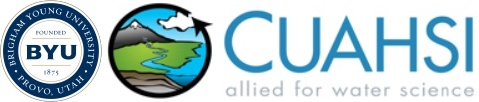

This Jupyter notebook contains Python functions which retrieve NWM forecasts from the NOAA Operational Model Archive and Distribution System (NOMADS) server, subset forecasts for a list of reaches, and export the subsetted data to CSV files. The NOMADS server only contains the current and previous day's NWM data. If you want to work with data from a specific time period, it can be obtained here:

https://console.cloud.google.com/storage/browser/national-water-model;tab=objects?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

That link takes you to a Google storage bucket where NWM data is being archived. Data from September of 2018 through today is available there. You could download data and move it into your Jupyter File Browser to subset it in this notebook, or you could run some of the Python code on your local device to subset the data on your own. It is also important to note that if you have opened this notebook in the CUAHSI JupyterHub environment that your available storage is limited. Large amounts of data may not fit. 

<em><h4>Imports</h4></em>

This next cell imports a few different Python modules or packages that will be used in this notebook. The functions and code in this notebook depend on these packages. If significant changes are made to a package it could affect the functionality of this notebook. The package version numbers originally used for some of the packages are included below along with a brief explanation of what each package will be used for.
* The os module allows us to communicate with the operating system. 
* The requests module lets us make requests to web pages. (2.27.1)
* Xarray lets us work with multidimensional datasets like the NWM forecasts. (0.2.1)
* Numpy helps us manipulate our data. (1.22.2)
* Pandas helps us get from netcdf to CSV. (1.4.0)
* Shutil helps us move files around. 
* Functools helps us manipulate some variables.
* Datetime helps us get todays date
* The CSV package lets us edit and work with CSV files. (1.0)

In [ ]:
# The following Python packages are used by the functions in this notebook
import os
import requests
import xarray as xr
import numpy as np
import pandas as pd
import shutil
from functools import reduce
from datetime import date
import csv
from csv import writer

<em><h4>Functions</h4></em>

The first two functions in this notebook should look familiar from previous NWM Notebooks. Some changes have been made to them for this particular notebook. The third and fourth functions are new. These subset nwm forecast files and export the subsetted streamflow forecast data to a CSV file respectively. 

In [ ]:
# This function builds the url for a specific forecast from the NOAA NWM http file delivery index (https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/)
# The urls are similar to this one: 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210320/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'
def GetForecastFileName(ForecastStartDate = '20210321', ForecastStartTimestep='00', ForecastType = 'short_range', ForecastMember='1', TimeStep = '001'):
  BaseName = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.'

  # The Different forecast types have slightly different urls. The following 'if elif' statements help build valid urls based on the forecast type given to the function.
  if (ForecastType == 'short_range'):
    return BaseName + ForecastStartDate + '/short_range/nwm.t' + ForecastStartTimestep +'z.short_range.channel_rt.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'medium_range'): 
    return BaseName + ForecastStartDate + '/medium_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.medium_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  elif (ForecastType == 'long_range'):
    return BaseName + ForecastStartDate + '/long_range_mem' + ForecastMember + '/nwm.t' + ForecastStartTimestep +'z.long_range.channel_rt_' + ForecastMember + '.f' + TimeStep + '.conus.nc'
  else:
    return 'error'

# This function downloads the given forecast file from NOAA using its url. You can see that we use os to communicate with the operating system and requests to 'get' what is at that url.
def GetForecastFile(Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  FileName = os.path.basename(Url)
  if os.path.exists(FileName):
    os.remove(FileName)
  r = requests.get(Url, allow_redirects=True)
  open(FileName, 'wb').write(r.content)
  
  return FileName

# This function downloads the given forecast file from NOAA using its url. You can see that we use os to communicate with the operating system and requests to 'get' what is at that url.
def GetForecastFiles(ForecastType = 'short_range', out_path = 'InitialForecastFiles', Url = 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/nwm.20210321/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc'):
  TimeSteps = []
  TimeSteps.clear()
  if (ForecastType=='short_range'):
    for i in range(18):
      TimeSteps.append("%03d" % (i+1))
  elif (ForecastType=='medium_range' and ForecastMember=='1'):
    for i in range(80):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='medium_range' and ForecastMember!='1'):
    for i in range (68):
      TimeSteps.append("%03d" % ((i+1)*3))
  elif (ForecastType=='long_range'):
    for i in range(120):
      TimeSteps.append("%03d" % ((i+1)*6))
  else: 
    return 'Error building time steps'
  
  for ts in TimeSteps:
    MyUrl = GetForecastFileName(ForecastStartDate,ForecastStartTimestep, ForecastType,ForecastMember,ts)
    FileName = GetForecastFile(MyUrl)
    if(FileName != 'error'):
      data = xr.open_dataset(FileName)
    else:
      print('Error getting forecast files.')
  files = [f for f in os.listdir('.') if os.path.isfile(f)]
  for f in files:
    if "nwm" in f and ForecastType in f and ".nc" in f:
        shutil.move(f, out_path + '/')


#This function subsets nwm netcdf files for a list of reach ids
def netcdf_subset_func(path='ForecastFiles', reaches=[101,179,181]):
    #Initialize empty list for reach indices
    indices = []
    #Put nwm reach index values into a numpyarray
    for i in os.listdir(in_path):
        if i.endswith('nc'):
            ds = xr.open_dataset(in_path + '/' + i)
            da = ds.coords['feature_id']
            numpyarray = da.values
            break
        break
        
    #Add desired reach indices to list        
    for reach in reaches:
        x = np.where(numpyarray==reach)
        s = reduce(lambda a, b: a + b, x)
        string = str(s)
        end = len(string) - 1
        index = string[1:end]
        indices.append(index)
        
    #Subset each nc file in folder for desired reaches
    for i in os.listdir(in_path):
        if i.endswith('nc'):
            ds2 = xr.open_dataset(in_path + '/' + i)
            sub = 'xr.concat(['
            for index in indices:
                isel = 'ds2.isel(indexers={\'feature_id\': ' + index + '}),'
                sub += isel
            final_sub = sub[0:-1] + '], dim="feature_id")'
            concat = eval(final_sub)
            concat.to_netcdf('sub'+i)
        files = [f for f in os.listdir('.') if os.path.isfile(f)]
        for f in files:
            if "subnwm" in f and ".conus.nc" in f:
                shutil.move(f, path + '/')
            
# This function exports subsetted nwm netcdf file streamflow forecasts to CSV files
def streamflow_to_csv(in_path='ForecastFiles'):
    #Initialize empty list and counter
    count = 0
    df_list=[]
    #For each file, drop unnecessary dimensions and variables, move to pandas, and reformat
    for i in os.listdir(in_path):
        if i.endswith('.conus.nc') and "subnwm" in i:
            count = count + 1
            ds = xr.open_dataset(in_path + '/' + i)
            ds2 = ds.drop_dims(["reference_time", "time"])
            ds2 = ds2.drop_vars(["crs","nudge","velocity","qSfcLatRunoff","qBucket","qBtmVertRunoff"])
            dsp = ds2.to_dataframe()
            string = str(i)
            string = string[0:-3]
            dsp = dsp.T
            dsp['Timestep:']=ds.time
            dsp = dsp.set_index('Timestep:')
            #Add the pandas dataframes from each nc file to a list
            df_list.append(dsp)

    #Concatenate dataframes
    df_comb = pd.concat(df_list)
    #Sort dataframe by index
    df_comb = df_comb.sort_index()
    
    #Compile some metadata
    fcinfo = "# " + string[0:-11]
    Source = "# Streamflow forecast retrieved using \'NWM Notebook 3: Subsetting\': https://www.hydroshare.org/resource/5949aec47b484e689573beeb004a2917/"
    RetrievedOn = "# Retrieved on: " + str(date.today())
    metadata = [fcinfo, Source, RetrievedOn]
    file_name = string[0:-11] + "_RetrievedOn:" + str(date.today()) + '.csv'
    
    #Output dataframe to CSV
    df_comb.to_csv("csvfrompd.csv")
    
    #Create empty dataframe/CSV for metadata header
    empty = pd.DataFrame()
    empty.to_csv(file_name)
    
    #Write metadata to csv
    for i in os.listdir():
        if i.endswith('.csv') and file_name in i: 
            with open(i, "w") as write_obj:
                csv_writer = writer(write_obj)
                csv_writer.writerow([fcinfo])
                csv_writer.writerow([Source])
                csv_writer.writerow([RetrievedOn])
    
    #Append streamflow forecast to CSV file with metadata header
    with open("csvfrompd.csv", 'r') as f1:
        forecast = f1.read()
    with open(file_name, 'a') as f2:
        f2.write('\n')
        f2.write(forecast)
    
    #Delete other CSV    
    files = [f for f in os.listdir('.') if os.path.isfile(f)]
    for f in files:
        if "csvfrompd" in f and f.endswith(".csv"):
            os.remove(f)

In order to proceed, <strong>you should create a folder in your Jupyter file browser</strong>. Name it ForecastFiles. This is just a convienient folder for all of the netcdf files to go. You can choose to name it something else if you would like to, just make sure that the folder name matches the folder names assigned to the path variables in the following cells. 

Also make sure to set the variables appropriately in the next cell. In particular, <strong>you will need to update the ForecastStartDate variable to either today's or yesterday's date in YYYYMMDD format.</strong> 

It is also important to note that the NWM NOMADS file directory that we are retrieving forecasts from operates on UTC time. As an example, if it is 6 PM on Feburary 3rd and you are on MST time, it is 1 AM on February 4th for the file directory. That means that if you try to retrieve February 2nd forecast files, they won't be available because the NOMADS directory operates on a two-day rolling window and would only have February 3rd forecasts and the February 4th forecasts as they become available throughout that day. Ensure that you provide a valid date to the ForecastStartDate variable below with that information in mind.

In [ ]:
# Set Variables

# Date in YYYYMMDD format. Can only be today or yesterday.
ForecastStartDate = '20220224'

# Timestep forecast was issued, 00 = midnight CST (Central Standard Time), Cannot exceed 24, 
# Cannot be in the future (Example: Today two hours from now)
# For short_range can be 00, 01, 02, 03, etc.
# For medium_range or long_range can be 00, 06, 12, etc.:
ForecastStartTimestep='00'

# Options are 'short_range', 'medium_range', and 'long_range':
ForecastType='short_range'

# Should be 1 for short_range. If using medium_range or 'long_range' then specify the ensemble member 
# (1-4 for long_range or 1-7 for medium_range):
ForecastMember='1'

# Just leave this one
TimeStep='001'

# This is the path to the folder where the initial nc files will be downloaded to
out_path = 'ForecastFiles'

In [ ]:
# Make sure the ForecastFiles folder is empty prior to running this cell.

# This uses the first function to get the proper url to retrieve the desired forecast files
URL = GetForecastFileName(ForecastStartDate=ForecastStartDate, ForecastStartTimestep=ForecastStartTimestep, ForecastType=ForecastType, ForecastMember=ForecastMember, TimeStep=TimeStep)

# Now we use the second function to actually retrieve the files
GetForecastFiles(ForecastType=ForecastType, out_path=out_path, Url = URL)

In [ ]:
# This should be the same location given to the out_path variable earlier
in_path = 'ForecastFiles'

# This is a list of river reaches that will be included in the subset
reaches = [3179510, 3179516, 101, 179]

In [ ]:
# This next line of code uses the third function from above to subset the netcdf files downloaded from the GetForecastFiles function
netcdf_subset_func(path=in_path, reaches=reaches)

In [ ]:
# This final line of code uses the fourth function from above to take the subset of data and put it into a CSV file.
# The file will appear in your Jupyter file browser after a moment. It will be called "subnwm ... .csv"
streamflow_to_csv(in_path=in_path)

Try downloading the CSV from your Jupyter file browser and opening it with Microsoft Excel or a similar program. 

<em><h4>Exercises</h4></em>

The last part of this notebook asks you to try a few things for yourself. Do your best to complete the 3 exercises below or answer the given questions by using what you've learned here. Feel free to add new cells to run any code that you might need to answer a question or complete a task.

1. Try subsetting a forecast that you download from the NWM Google Storage bucket linked to at the beginning of this notebook. Choose a short range channel forecast for any day. You'll need to download 18 forecast files and put them in your 'ForecastFiles' folder that you created earlier. A screenshot of the short range forecast files that were outputted on September 19th, 2018 at midnight UTC is shown below. Now you should be able to use the netcdf_subset_func and streamflow_to_csv functions to subset those files and export their streamflow forecasts to a CSV.

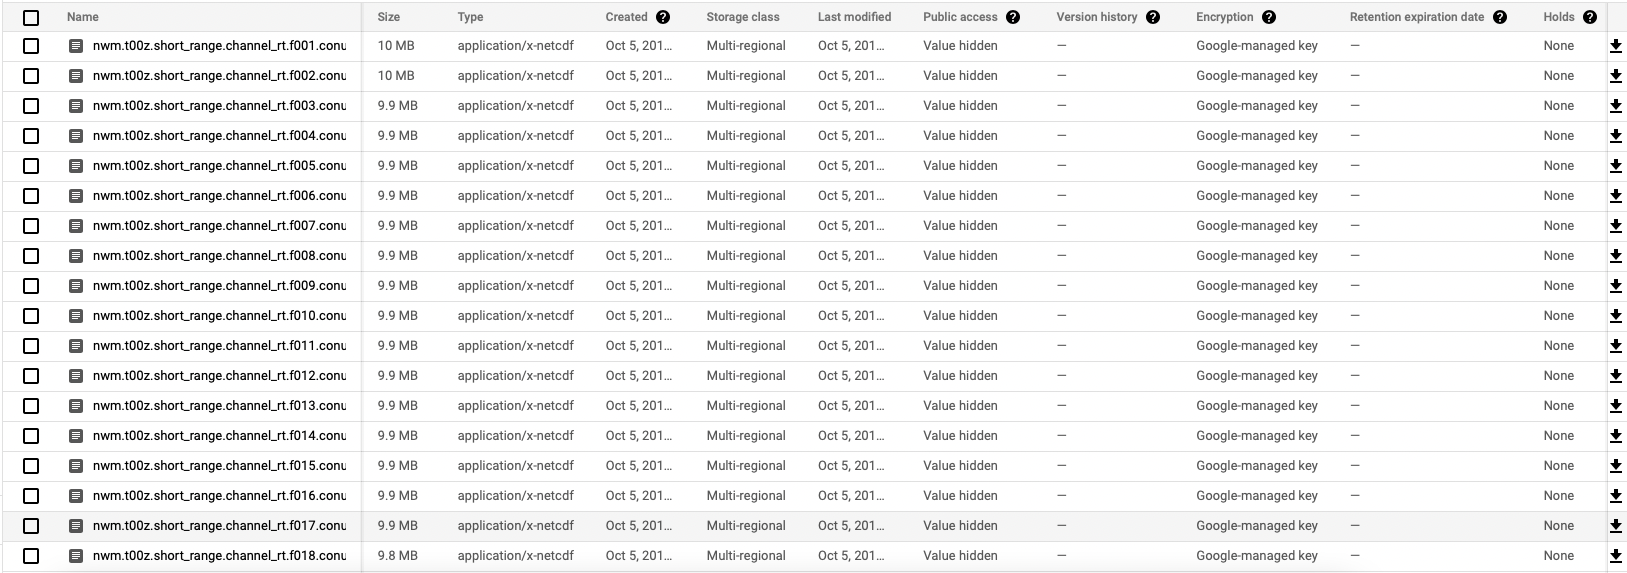

2. The streamflow_to_csv function drops all of the variables in the nwm data except for streamflow before exporting the data to a CSV. Try editing this function or creating an additional function to export velocity data instead of streamflow. It's probably easier than you might think. After you've made changes to the function, try exporting some data to a CSV again. 

3. Try editing the list of reaches that have been included in your data subset. Pick at least 5 reaches for a river of interest. You can obtain the desired reach ids from the NWM interactive map at https://water.noaa.gov/map or from the simple JavaScript map that we used in NWM Notebook 2 at https://byu-hydroinformatics.github.io/csb-jr233/. Subset some nwm data for these reaches and export their streamflow or velocity forecasts to a CSV. Observe and consider how streamflow or velocity changes as you move up or downstream. 

Thank you for using this resource! Hopefully it can help you subset National Water Model forecasts and obtain actionable forecast data in a useful format for a river near you.